In [7]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# 1. Cargar dataset
df = pd.read_csv("features_sample_2porciento.csv")

# 2. Limpiar nombres de columnas
def limpiar_nombre(col):
    return (
        col.replace("(", "_")
           .replace(")", "")
           .replace(",", "_")
           .replace(".", "_")
           .replace(" ", "_")
    )

df.columns = [limpiar_nombre(c) for c in df.columns]

# 3. Convertir columnas categóricas
for col in df.select_dtypes(include="object").columns:
    df[col] = df[col].astype("category")

# 4. Separar X e y
y = df["tn"]
X = df.drop(columns=["tn"])

# 5. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 6. Datasets LightGBM
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test)

# 7. Parámetros
params = {
    "objective": "regression",
    "metric": "rmse",
    "learning_rate": 0.1,
    "num_leaves": 31,
    "device": "gpu",  # ⚠️ usar GPU
    "verbosity": -1
}

# 8. Entrenar modelo
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, valid_data],
    num_boost_round=1000,
    callbacks=[
        lgb.early_stopping(50),
        lgb.log_evaluation(50)
    ]
)

# 9. Predicción y evaluación
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # corregido
print(f"📊 RMSE: {rmse:.4f}")

# 10. Importancia de variables
importancia = pd.DataFrame({
    "feature": model.feature_name(),
    "importance": model.feature_importance()
}).sort_values(by="importance", ascending=False)

print("\n🏅 Top 20 features más importantes:")
print(importancia.head(20))



Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.363858	valid_1's rmse: 0.540301
Early stopping, best iteration is:
[29]	training's rmse: 0.440182	valid_1's rmse: 0.525174
📊 RMSE: 0.5252

🏅 Top 20 features más importantes:
                                               feature  importance
5                                      cust_request_tn         328
17                                             DIFF_tn         173
4                                     cust_request_qty          22
33                   ROLLING_MEAN_periodo__stock_final          20
28                                       MONTH_periodo          19
32                      ROLLING_MEAN_periodo__sku_size          18
26                            LAG_stock_final__periodo          16
0                                             venta_id          15
13                                DIFF_cust_request_tn          15
80                productos_MAX_ventas_cust_request_tn          12
30  

In [14]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# 1. Cargar y limpiar
df = pd.read_csv("features_sample_2porciento.csv")

def limpiar_nombre(col):
    return col.replace("(", "_").replace(")", "").replace(",", "_").replace(".", "_").replace(" ", "_")

df.columns = [limpiar_nombre(c) for c in df.columns]

# 2. Convertir columnas categóricas
for col in df.select_dtypes(include="object").columns:
    df[col] = df[col].astype("category")

df["product_id"] = df["product_id"].astype("category")
df["customer_id"] = df["customer_id"].astype("category")

# 3. Separar X e y
y = df["tn"]
X = df.drop(columns=["tn"])

# 4. Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Dataset LightGBM
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=["product_id", "customer_id"])
valid_data = lgb.Dataset(X_test, label=y_test)

# 6. Parámetros CPU
params = {
    "objective": "regression",
    "metric": "rmse",
    "device": "cpu",  # ⚠️ CPU por alta cardinalidad
    "verbosity": -1
}

# 7. Entrenamiento
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, valid_data],
    num_boost_round=1000,
    callbacks=[
        lgb.early_stopping(50),
        lgb.log_evaluation(50)
    ]
)

# 8. Evaluación
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"📊 RMSE con IDs (CPU): {rmse:.4f}")

# 9. Importancia
importancia = pd.DataFrame({
    "feature": model.feature_name(),
    "importance": model.feature_importance()
}).sort_values(by="importance", ascending=False)


print("\n🏅 Top 20 features más importantes:")
print(importancia.head(20))

importancia.to_csv("importancia_con_ids_cpu.csv", index=False)


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.364808	valid_1's rmse: 0.539196
Early stopping, best iteration is:
[25]	training's rmse: 0.455401	valid_1's rmse: 0.526433
📊 RMSE con IDs (CPU): 0.5264

🏅 Top 20 features más importantes:
                                               feature  importance
5                                      cust_request_tn         302
17                                             DIFF_tn         153
0                                             venta_id          23
80                productos_MAX_ventas_cust_request_tn          21
32                      ROLLING_MEAN_periodo__sku_size          20
33                   ROLLING_MEAN_periodo__stock_final          15
4                                     cust_request_qty          15
28                                       MONTH_periodo          14
26                            LAG_stock_final__periodo          12
13                                DIFF_cust_request_tn   

In [15]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

df = pd.read_csv("features_sample_2porciento.csv")

def limpiar_nombre(col):
    return col.replace("(", "_").replace(")", "").replace(",", "_").replace(".", "_").replace(" ", "_")

df.columns = [limpiar_nombre(c) for c in df.columns]

# Convertir columnas object a category
for col in df.select_dtypes(include="object").columns:
    df[col] = df[col].astype("category")

# Eliminar identificadores
df = df.drop(columns=["product_id", "customer_id"], errors="ignore")

y = df["tn"]
X = df.drop(columns=["tn"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test)

params = {
    "objective": "regression",
    "metric": "rmse",
    "device": "gpu",
    "verbosity": -1
}

model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, valid_data],
    num_boost_round=1000,
    callbacks=[
        lgb.early_stopping(50),
        lgb.log_evaluation(50)
    ]
)

y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"📉 RMSE sin IDs: {rmse:.4f}")

importancia = pd.DataFrame({
    "feature": model.feature_name(),
    "importance": model.feature_importance()
}).sort_values(by="importance", ascending=False)

print("\n🏅 Top 20 features más importantes:")
print(importancia.head(20))

importancia.to_csv("importancia_sin_ids.csv", index=False)


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.363868	valid_1's rmse: 0.541629
Early stopping, best iteration is:
[29]	training's rmse: 0.440176	valid_1's rmse: 0.524905
📉 RMSE sin IDs: 0.5249

🏅 Top 20 features más importantes:
                                               feature  importance
3                                      cust_request_tn         329
15                                             DIFF_tn         173
2                                     cust_request_qty          23
31                   ROLLING_MEAN_periodo__stock_final          21
26                                       MONTH_periodo          19
0                                             venta_id          18
24                            LAG_stock_final__periodo          16
30                      ROLLING_MEAN_periodo__sku_size          16
78                productos_MAX_ventas_cust_request_tn          16
11                                DIFF_cust_request_tn         

In [16]:
import pandas as pd

# 🟦 Importancia con IDs
con_ids = {
    'feature': [
        'cust_request_tn', 'DIFF_tn', 'venta_id', 'productos_MAX_ventas_cust_request_tn',
        'ROLLING_MEAN_periodo__sku_size', 'ROLLING_MEAN_periodo__stock_final',
        'cust_request_qty', 'MONTH_periodo', 'LAG_stock_final__periodo',
        'DIFF_cust_request_tn', 'DIFF_cust_request_qty', 'productos_MEAN_ventas_cust_request_tn',
        'LAG_cat2__periodo', 'clientes_NUM_CONSECUTIVE_GREATER_MEAN_ventas_cust_request_tn',
        'clientes_MEAN_ventas_sku_size', 'clientes_MIN_ventas_stock_final',
        'productos_MEAN_ventas_stock_final', 'productos_NUM_CONSECUTIVE_GREATER_MEAN_ventas_stock_final',
        'DIFF_sku_size', 'stock_final'
    ],
    'importance': [
        302, 153, 23, 21, 20, 20, 15, 14, 12, 11, 11, 10, 8, 8, 7, 7, 7, 7, 7, 6
    ]
}
df_con = pd.DataFrame(con_ids)

# 🟥 Importancia sin IDs
sin_ids = {
    'feature': [
        'cust_request_tn', 'DIFF_tn', 'cust_request_qty', 'ROLLING_MEAN_periodo__stock_final',
        'MONTH_periodo', 'venta_id', 'LAG_stock_final__periodo', 'ROLLING_MEAN_periodo__sku_size',
        'productos_MAX_ventas_cust_request_tn', 'DIFF_cust_request_tn', 'productos_MEAN_ventas_stock_final',
        'productos_MAX_ventas_tn', 'ROLLING_MEAN_periodo__cust_request_tn',
        'productos_NUM_CONSECUTIVE_GREATER_MEAN_ventas_stock_final',
        'clientes_MEAN_ventas_sku_size', 'DIFF_cust_request_qty', 'DIFF_stock_final',
        'DIFF_sku_size', 'clientes_MIN_ventas_stock_final',
        'clientes_NUM_CONSECUTIVE_GREATER_MEAN_ventas_cust_request_tn'
    ],
    'importance': [
        329, 173, 23, 21, 19, 18, 16, 16, 12, 13, 11, 10, 10, 10, 10, 10, 9, 9, 9, 8
    ]
}
df_sin = pd.DataFrame(sin_ids)

# 🔁 Comparar
df_comparado = pd.merge(df_con, df_sin, on='feature', how='outer', suffixes=('_con', '_sin')).fillna(0)
df_comparado["diff_importancia"] = df_comparado["importance_con"] - df_comparado["importance_sin"]

# 🏆 Ranking final
df_comparado = df_comparado.sort_values(by="diff_importancia", ascending=False)

# 💾 Exportar
df_comparado.to_csv("comparativa_importancia.csv", index=False)

# 👀 Mostrar
print(df_comparado.head(20))


                                              feature  importance_con  \
18              productos_MEAN_ventas_cust_request_tn            10.0   
16               productos_MAX_ventas_cust_request_tn            21.0   
5                                   LAG_cat2__periodo             8.0   
21                                        stock_final             6.0   
22                                           venta_id            23.0   
9                      ROLLING_MEAN_periodo__sku_size            20.0   
0                               DIFF_cust_request_qty            11.0   
13  clientes_NUM_CONSECUTIVE_GREATER_MEAN_ventas_c...             8.0   
10                  ROLLING_MEAN_periodo__stock_final            20.0   
1                                DIFF_cust_request_tn            11.0   
2                                       DIFF_sku_size             7.0   
12                    clientes_MIN_ventas_stock_final             7.0   
20  productos_NUM_CONSECUTIVE_GREATER_MEAN_ventas_.

C:\Users\waldo\AppData\Local\Temp\ipykernel_32260\2303600789.py:19: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\waldo\miniconda3\envs\lgbmgpu\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


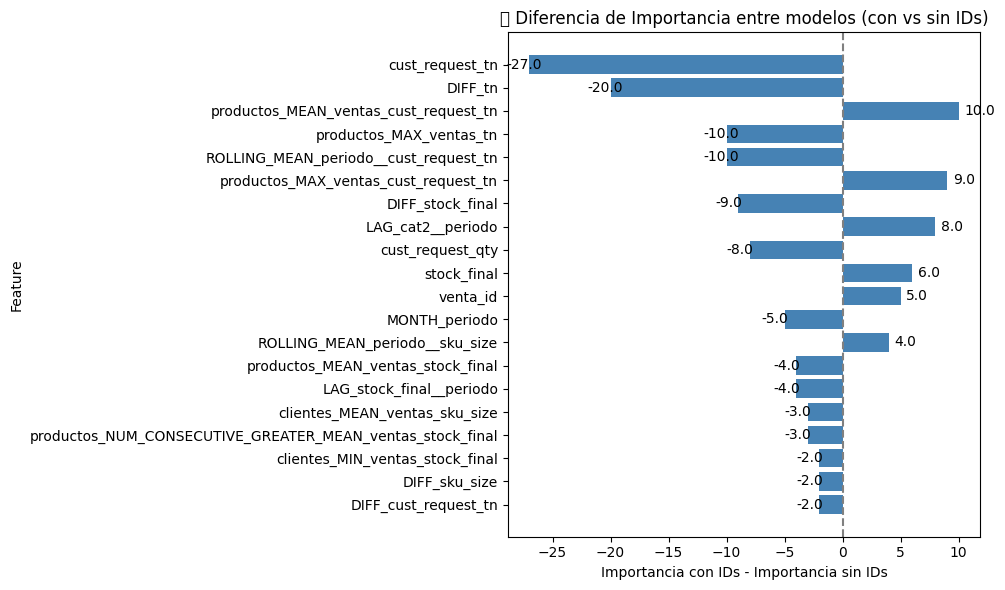

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# 📥 Leer archivo exportado anteriormente
df = pd.read_csv("comparativa_importancia.csv")

# 🪓 Filtrar top diferencias absolutas (para que se vea algo relevante)
df["abs_diff"] = df["diff_importancia"].abs()
df_top = df.sort_values(by="abs_diff", ascending=False).head(20)

# 🎨 Gráfico de barras
plt.figure(figsize=(10, 6))
bars = plt.barh(df_top["feature"], df_top["diff_importancia"], color="steelblue")
plt.axvline(0, color="gray", linestyle="--")

plt.title("🔍 Diferencia de Importancia entre modelos (con vs sin IDs)")
plt.xlabel("Importancia con IDs - Importancia sin IDs")
plt.ylabel("Feature")
plt.tight_layout()
plt.gca().invert_yaxis()  # Lo más importante arriba

# 🧩 Mostrar valores sobre las barras
for bar in bars:
    plt.text(
        bar.get_width() + (0.5 if bar.get_width() >= 0 else -2),
        bar.get_y() + bar.get_height() / 2,
        f"{bar.get_width():.1f}",
        va="center"
    )

plt.show()
